In [1]:
# 라이브러리 
import os
import time
import copy
import glob
import cv2
import shutil
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
from google.colab import files

In [3]:
file_uploaded = files.upload() # 데이터 업로드

Saving catanddog.zip to catanddog.zip


In [4]:
!unzip catanddog.zip -d catanddog/

Archive:  catanddog.zip
   creating: catanddog/test/
   creating: catanddog/test/Cat/
  inflating: catanddog/test/Cat/8100.jpg  
  inflating: catanddog/test/Cat/8101.jpg  
  inflating: catanddog/test/Cat/8102.jpg  
  inflating: catanddog/test/Cat/8103.jpg  
  inflating: catanddog/test/Cat/8104.jpg  
  inflating: catanddog/test/Cat/8105.jpg  
  inflating: catanddog/test/Cat/8106.jpg  
  inflating: catanddog/test/Cat/8107.jpg  
  inflating: catanddog/test/Cat/8108.jpg  
  inflating: catanddog/test/Cat/8109.jpg  
  inflating: catanddog/test/Cat/8110.jpg  
  inflating: catanddog/test/Cat/8111.jpg  
  inflating: catanddog/test/Cat/8112.jpg  
  inflating: catanddog/test/Cat/8113.jpg  
  inflating: catanddog/test/Cat/8114.jpg  
  inflating: catanddog/test/Cat/8115.jpg  
  inflating: catanddog/test/Cat/8116.jpg  
  inflating: catanddog/test/Cat/8117.jpg  
  inflating: catanddog/test/Cat/8118.jpg  
  inflating: catanddog/test/Cat/8119.jpg  
  inflating: catanddog/test/Cat/8120.jpg  
  inflating

In [5]:
data_path = 'catanddog/train/'
transform = transforms.Compose(
    [
      transforms.Resize([256,256]),
      transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor()
    ]
)
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)
print(len(train_dataset))

385


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


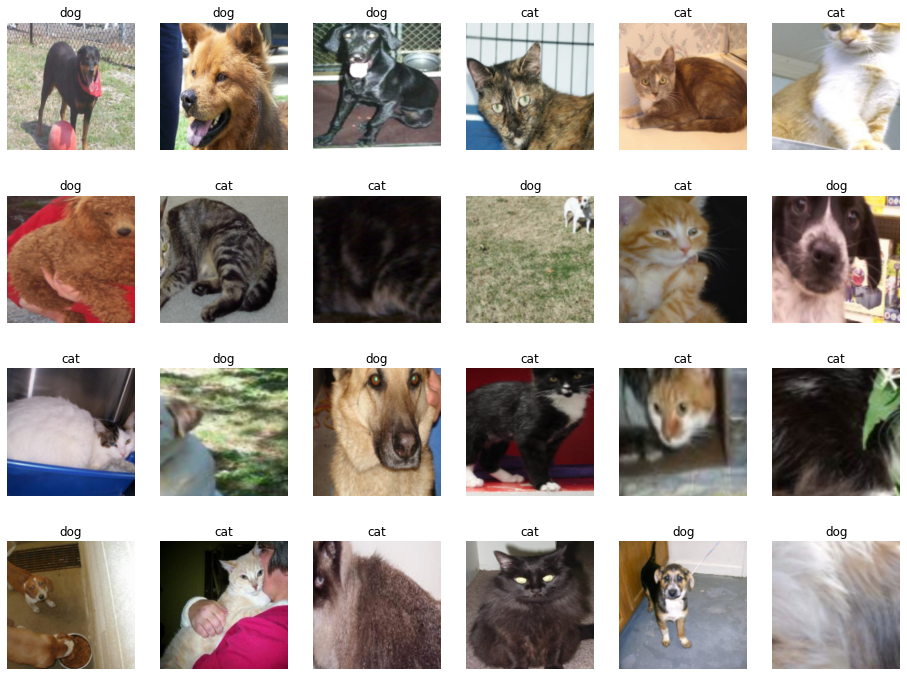

In [6]:
# 이미지 데이터 확인
import numpy as np
samples,labels= iter(train_loader).next()
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(1, 24+1):
  a = fig.add_subplot(4,6,i)
  a.set_title(classes[labels[i].item()])
  a.axis('off')
  a.imshow(np.transpose(samples[i].numpy(),(1,2,0)))
plt.subplots_adjust(bottom = 0.2, top=0.6,hspace=0)  

In [7]:
# 전이학습
resnet18 = models.resnet18(weights=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [8]:
# 기존에 학습된 가중치를 사용하되
# 파라메터에 대해선든 학습을 하지 않도록 고정
def set_parameter_requires_grad(model, feature_extracting=True):
  if feature_extracting:
    for param in model.parameters():
      param.requires_grad = False
set_parameter_requires_grad(resnet18)      

In [9]:
# resnet18  (fc): Linear(in_features=512, out_features=1000, bias=True)  1000개의 분류 모델
# 여기에다가 마지작에 개 고양이 두개를 분리할수있도록 층을 교체 2진 분류 모델로 변경

In [10]:
resnet18.fc = nn.Linear(in_features=512, out_features=2)

In [11]:
# 파라메터 확인
for name,param in  resnet18.named_parameters():
  if param.requires_grad:
    print(name, param.data)

fc.weight tensor([[-0.0350,  0.0147, -0.0197,  ...,  0.0198,  0.0063, -0.0247],
        [-0.0312,  0.0162, -0.0366,  ..., -0.0220,  0.0365, -0.0135]])
fc.bias tensor([ 0.0268, -0.0184])


In [12]:
model = models.resnet18(weights=True)
# 합성곱층 가중치 고정
for param in model.parameters():
  param.requires_grad = False

model.fc = nn.Linear(in_features=512, out_features=2)
# 추가한 완전 연결층은 학습
for param in model.fc.parameters():
  param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
# 모델 학습을 위한 함수 
def train_model(model, dataloaders,criterion, optimizer, device, num_epochs=13, is_train=True):
  since = time.time() # 현재시간
  acc_history = []
  loss_history = []
  best_acc = 0.0
  for epoch in range(num_epochs):
    print(f"Epoch {epoch}/{num_epochs-1}")
    print('-'*10)
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in dataloaders:
      inputs = inputs.to(device)
      labels = labels.to(device)
      model.to(device)
      optimizer.zero_grad()  # 기울기를 0으로 설정
      outputs = model(inputs) # 순전파 학습
      loss = criterion(outputs, labels)
      _,preds = torch.max(outputs,1)
      loss.backward() # 역전파 학습
      optimizer.step()  # 옵티마이져 적용

      running_loss += loss.item()*inputs.size(0) # 출력결과와 레이블 오차를 계산한결과 누적
      running_corrects += torch.sum(preds == labels.data) # 동일한지
    epoch_loss = running_loss / len(dataloaders.dataset)  # 평균오차
    epoch_acc = running_corrects.double() / len(dataloaders.dataset)  # 평균 정확도

    print(f"Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
    if epoch_acc > best_acc:
      best_acc = epoch_acc

    acc_history.append(epoch_acc.item())
    loss_history.append(epoch_loss)
    torch.save(model.state_dict(), os.path.join('catanddog/','{0:0=2d}'.format(epoch)) )  # 모델 저장(재사용)
    print()
  time_elapsed = time.time() - since   # 소요시간 측정
  print(f"Training complete in {time_elapsed//60:.0f}m  {time_elapsed%60:.0f}s")
  print(f"Best Acc:{best_acc:4f}")
  return acc_history, loss_history

In [17]:
params_to_update = []
# ResNet18에 추가된 완전연결층을 학습하도록 설정
# 이때 얻어지는 파라메터를 옵티마이져에 전달해서 최정적으로 모델 학습에 사용
for name, param in resnet18.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param) # 파라메터 학습결과 저장
    print('\t', name)
optimizer = optim.Adam(params_to_update)    # 학습결과를 옵티마이져에 전달

	 fc.weight
	 fc.bias


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss() # 손실함수 지정
train_acc_hist, train_loss_hist =  train_model(resnet18,train_loader, criterion,optimizer,device)

Epoch 0/12
----------
Loss: 0.4279 Acc: 0.8416

Epoch 1/12
----------
Loss: 0.3077 Acc: 0.8935

Epoch 2/12
----------
Loss: 0.3032 Acc: 0.8753

Epoch 3/12
----------
Loss: 0.2444 Acc: 0.9117

Epoch 4/12
----------
Loss: 0.2551 Acc: 0.8831

Epoch 5/12
----------
Loss: 0.2117 Acc: 0.9403

Epoch 6/12
----------
Loss: 0.2336 Acc: 0.9247

Epoch 7/12
----------
Loss: 0.2265 Acc: 0.8883

Epoch 8/12
----------
Loss: 0.2234 Acc: 0.9039

Epoch 9/12
----------
Loss: 0.2328 Acc: 0.8831

Epoch 10/12
----------
Loss: 0.2457 Acc: 0.8987

Epoch 11/12
----------
Loss: 0.1810 Acc: 0.9221

Epoch 12/12
----------
Loss: 0.2048 Acc: 0.9117

Training complete in 0m  34s
Best Acc:0.940260
